In [1]:
# http://www.comp.nus.edu.sg/~nlp/sw/sm_norm_mt.tar.gz

!wget --header="Host: www.comp.nus.edu.sg" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: visid_incap_2099644=pef/mQ77TZqxGIM+XZcTLuObGGEAAAAAQUIPAAAAAACn862R5L9R7FqXdhF52R2d; nlbi_2099644_1953083=kVbsMhbbHCdGgIzADqPFWwAAAABZzyG0W+p9jHk/NTK28ErZ; incap_ses_9210_2099644=9LPHHd2ZPiv/Qzz5a37Qf+SbGGEAAAAAmH691xWW9ZDVkuUJRUy8lw==" --header="Connection: keep-alive" "https://www.comp.nus.edu.sg/~nlp/sw/sm_norm_mt.tar.gz" -c -O 'sm_norm_mt.tar.gz'

--2021-08-20 02:48:47--  https://www.comp.nus.edu.sg/~nlp/sw/sm_norm_mt.tar.gz
Resolving www.comp.nus.edu.sg (www.comp.nus.edu.sg)... 45.60.31.225
Connecting to www.comp.nus.edu.sg (www.comp.nus.edu.sg)|45.60.31.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180034 (176K) [application/x-gzip]
Saving to: ‘sm_norm_mt.tar.gz’

sm_norm_mt.tar.gz   100%[===================>] 175.81K   196KB/s    in 0.9s    

2021-08-20 02:48:49 (196 KB/s) - ‘sm_norm_mt.tar.gz’ saved [180034/180034]



In [2]:
# extracting the file
!tar -xvf '/content/sm_norm_mt.tar.gz'

release/
release/en2cn-2k.en2nen2cn
release/README


In [3]:
file_ = list()

for line in open('/content/release/en2cn-2k.en2nen2cn'):
    file_.append(line)

In [4]:
# declaring list variable to store corrupted text and english text
corrupted_text = list()
english_text = list()

for i in range(len(file_)):
    # storing corrupted text in a list
    if i % 3 == 0:
        corrupted_text.append(file_[i])
    # storing engish text in a list
    elif i % 3 == 1:
        english_text.append(file_[i])
    # not storing the chinese text as correction is to be done on english text 
    elif i % 3 == 2:
        pass

In [5]:
# importing libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
dict_ = {'corrupted_text': corrupted_text, 'english_text' : english_text}

# converting the above dictionary to DataFrame
df = pd.DataFrame(dict_)
df.head()

,corrupted_text,english_text
0,"U wan me to ""chop"" seat 4 u nt?\n",Do you want me to reserve seat for you or not?\n
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?\n,I'm Thai. What do you do?\n
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [7]:
# saving the dataframe to disk
# commenting the below code because we don't want to change the file in disk everytime we run the above code
# and change it whenever needed

# df.to_csv('/content/drive/MyDrive/seq2seq/data.csv', index=False)

## Exploratory Data Analysis

In [8]:
# reading the dataframe from disk
data = pd.read_csv('/content/drive/MyDrive/seq2seq/data.csv')
data.head()

,corrupted_text,english_text
0,"U wan me to ""chop"" seat 4 u nt?\n",Do you want me to reserve seat for you or not?\n
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?\n,I'm Thai. What do you do?\n
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [9]:
# checking for null values

data.isnull().any()

corrupted_text    False
english_text      False
dtype: bool

*   there are no empty string in the dataframe




In [10]:
# checking for duplicate values
data.duplicated().sum()

0

* there are no duplicate column present in dataframe

In [11]:
# splitting the sentences by words and calculating their respective lengths
corrupted_text_words_len = data.corrupted_text.apply(lambda x: len(str(x).split()))
english_text_words_len   = data.english_text.apply(lambda x: len(str(x).split()))

# calculating the length of sentences including spaces
corrupted_text_sentence_len = data.corrupted_text.apply(lambda x: len(x))
english_text_sentence_len   = data.english_text.apply(lambda x: len(x))

### For corrupted_text word length

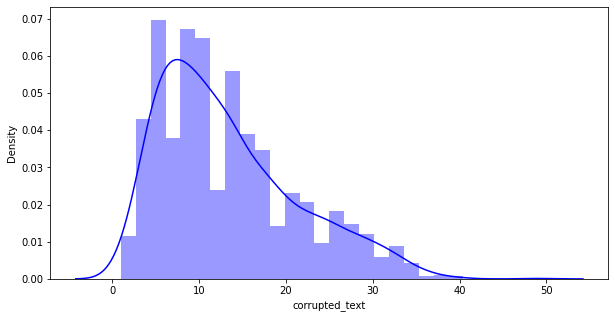

In [12]:
fig = plt.figure(figsize=(10,5))
sns.distplot(corrupted_text_words_len, color='blue')
plt.show()

* the above graph is a right skewed distribution 
* most of the word count in a sentence are high in range (0, 15)
* as the graph is right skewed very few sentences with word count can be seen after 40.
* to make a better sense out of it, we will check for percentiles value and set a thresold accordingly for padding.

In [13]:
# printing the percentile in range 90 - 100 for corrupted text
for i in range(90,101):
    print(i,np.percentile(corrupted_text_words_len, i))

90 25.0
91 26.0
92 27.0
93 28.0
94 28.0
95 29.0
96 30.0
97 31.0
98 32.01999999999998
99 34.0
100 49.0


* the values are increasing in a moderate manner between 90 - 99 percentile
* there is a sudden increase in value in between 99 and 100 percentile, so we will zoom in this range 

In [14]:
# printing the percentile in range 90 - 100
for i in np.arange(0,1.1,0.1):
    print(99+i,np.percentile(corrupted_text_words_len, 99 + i))

99.0 34.0
99.1 35.0
99.2 35.0
99.3 35.0
99.4 35.0
99.5 36.0
99.6 36.003999999999905
99.7 37.0
99.8 37.003999999999905
99.9 39.001000000000204
100.0 49.0


* the values are increasing gradually in range between 99.0 - 99.9 percentile.
* there is a sudden increase in value from 99.9 to 100 percentile therefore we will set the thresold at 99.9 percentile whose value is 39

### For corrupted_text length including spaces


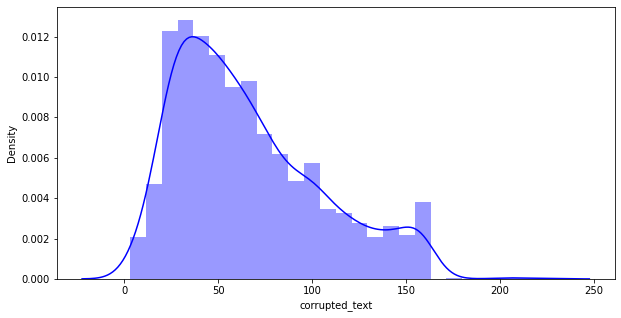

In [15]:
fig = plt.figure(figsize=(10,5))
sns.distplot(corrupted_text_sentence_len, color='blue')
plt.show()

* the graph is right skewed 
* the values are high in range (10, 100)
* the values are decreasing nearly from 175, so we will check go for percentiles values

In [16]:
# printing the percentile in range 90 - 100 for corrupted text
for i in range(90,101):
    print(i,np.percentile(corrupted_text_sentence_len, i))

90 126.0
91 130.0
92 135.0
93 139.0
94 143.0
95 148.0
96 152.0
97 155.0
98 158.0
99 160.0
100 222.0


* the values are increasing gradually.
* the increase is very high in percentile between 99 - 100, so well will zoom in this range

In [17]:
# printing the percentile in range 90 - 100
for i in np.arange(0,1.1,0.1):
    print(99+i,np.percentile(corrupted_text_sentence_len, 99 + i))

99.0 160.0
99.1 160.0
99.2 160.00800000000004
99.3 161.0
99.4 161.0
99.5 161.0
99.6 161.0
99.7 161.0
99.8 162.01999999999953
99.9 203.0030000000006
100.0 222.0


* the values are gradually increasing, but there is a sudden increase in value in percentile from 99.8 to 99.9
* so setting the thresold to 99.8 percentile whose value is 162.

### For english_text word length

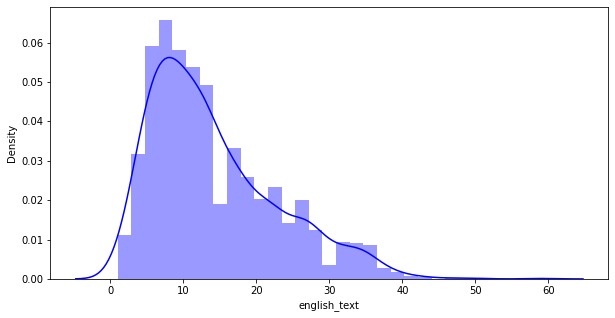

In [18]:
fig = plt.figure(figsize=(10,5))
sns.distplot(english_text_words_len, color='blue')
plt.show()

* the graph is right skewed 
* the word count of sentence are high in range 5-15.
* the values are decreasing above 40 value, checking for percentile to see the increase in values.

In [19]:
# printing the percentile in range 90 - 100 for corrupted text
for i in range(90,101):
    print(i,np.percentile(english_text_words_len, i))

90 27.0
91 28.0
92 29.0
93 29.070000000000164
94 31.0
95 32.0
96 33.0
97 34.0
98 35.01999999999998
99 38.0
100 59.0


* the values are gradually increasing in range 90 - 99
* there is a steep increase in value from 99 - 100 percentile, so we will zoom in this range.

In [20]:
# printing the percentile in range 90 - 100
for i in np.arange(0,1.1,0.1):
    print(99+i,np.percentile(english_text_words_len, 99 + i))

99.0 38.0
99.1 38.0
99.2 38.00800000000004
99.3 39.0
99.4 39.0
99.5 40.0
99.6 41.003999999999905
99.7 42.00299999999993
99.8 43.00599999999986
99.9 48.00200000000041
100.0 59.0


* seeing the above values there is a gradual increase in values in range from 99.0 - 99.9.
* but values increase dramatically from 99.9 - 100 percentile, so setting the thresold to 99.9 percentile value which is 48.

### For english_text length including spaces

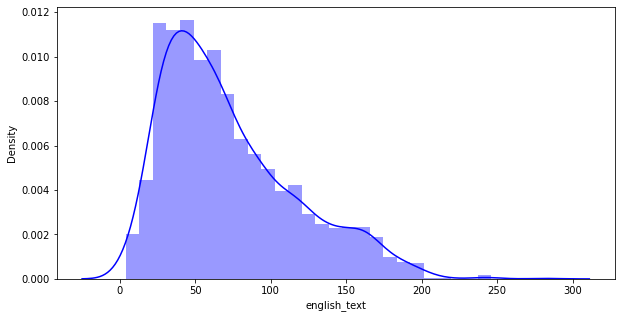

In [21]:
fig = plt.figure(figsize=(10,5))
sns.distplot(english_text_sentence_len, color='blue')
plt.show()

* the graph is right skewed
* there are high number of sentences in range 30 - 75.
* the values are gradually decreasing above 200, so checking the percentile values.

In [22]:
# printing the percentile in range 90 - 100 for corrupted text
for i in range(90,101):
    print(i,np.percentile(english_text_sentence_len, i))

90 141.0
91 145.0
92 150.0
93 155.0
94 157.0
95 163.0
96 166.0
97 171.0
98 180.01999999999998
99 191.01
100 282.0


* the values are gradually increasing, but there is a slight increase in percentile values above 97 percentile.

In [23]:
# printing the percentile in range 90 - 100
for i in np.arange(0,1.1,0.1):
    print(99+i,np.percentile(english_text_sentence_len, 99 + i))

99.0 191.01
99.1 193.0
99.2 193.01600000000008
99.3 197.00700000000006
99.4 198.0
99.5 199.00499999999988
99.6 201.0
99.7 201.0209999999995
99.8 216.04999999999882
99.9 242.0030000000006
100.0 282.0


* the values are gradually increasing but there is a steep increase from 99.8 to 99.9 and from 99.9 to 100 percentile.
* setting the thresold at 99.8 percentile value, which is 216.

In [24]:
text = ''
for i in data.corrupted_text.values:
    text += ' ' + i

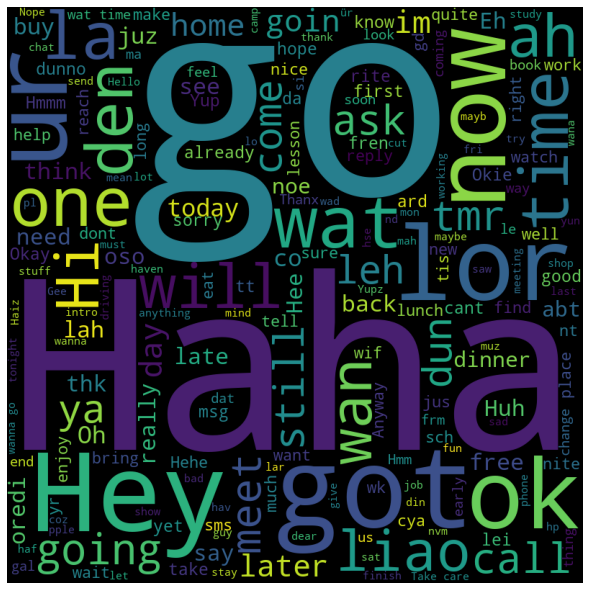

In [25]:
# reference: https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(str(text))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)                
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

the above are the most used words, there are some of the words which use abbreviations (or short form). 

In [26]:
text = ''
for i in data.english_text.values:
    text += ' ' + i

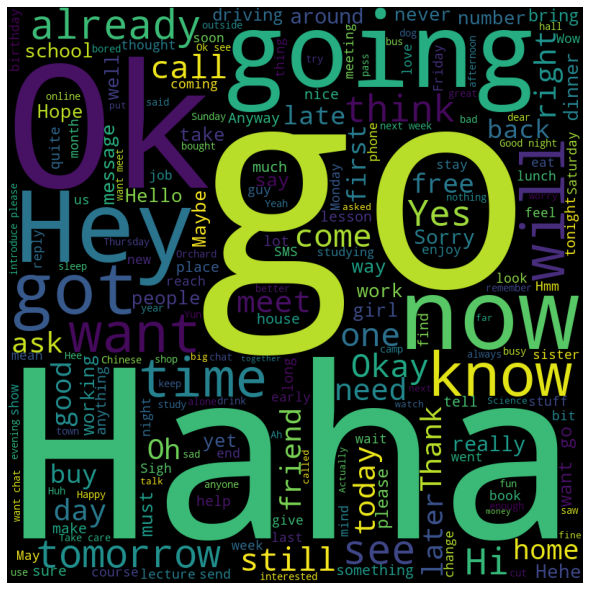

In [27]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)                
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

the above word cloud is in proper english words without abbreviation(or short form).